# OSNA Assignment 2 -
# A20563287
# Data Set 1 - Chicago #Community Areas
To create this model, I made the following assumptions:

Shared Boundary: An edge exists between two community areas if they share a border of any length. Two areas that meet at a single point (a corner) are not considered adjacent.

In [29]:
import os, glob, geopandas as gpd, networkx as nx, matplotlib.pyplot as plt


print("CWD:", os.getcwd())
print("Files here:", os.listdir())

# === Input paths ===
GEOJSON_PATH = "Boundaries_-_Community_Areas_20250915.geojson"

# Sanity check
if not os.path.exists(GEOJSON_PATH):
    # helpful fallback if someone renames or moves it:
    cand = glob.glob("*.geojson") + glob.glob("**/*.geojson", recursive=True)
    raise FileNotFoundError(f"GeoJSON not found. Looked for {GEOJSON_PATH}. "
                            f"GeoJSONs I can see: {cand}")


CWD: C:\Users\anuja\OneDrive\Desktop\A20563287_Assignment 2
Files here: ['.ipynb_checkpoints', 'Boundaries_-_Community_Areas_20250915.geojson', 'chicago_outputs', 'input file 1.ipynb', 'input file 2.ipynb', 'Social Network Data collection(Sheet1).csv']


# (1a) Build adjacency graph (share a boundary segment)

In [4]:
import geopandas as gpd, networkx as nx
from shapely.geometry import Point

# 1) Read polygons
gdf = gpd.read_file(GEOJSON_PATH)

# 2) Pick reasonable name/id columns from the Chicago CA dataset
#    (common columns are 'community' and 'area_numbe' / 'area_num_1')
lower = {c: c.lower() for c in gdf.columns}
name_col = next((c for c in gdf.columns if c.lower() in ("community","community_area","community_area_name","name")), None)
id_col   = next((c for c in gdf.columns if c.lower() in ("area_numbe","area_num_1","area_num","id")), None)

if name_col is None:
    name_col = "name"
    gdf[name_col] = [f"Area {i}" for i in range(len(gdf))]
if id_col is None:
    id_col = "id"
    gdf[id_col] = range(1, len(gdf)+1)

# 3) Build adjacency edges when polygons touch along a boundary (not just a point)
def shares_boundary(p1, p2):
    # true if they touch and the shared intersection has non-zero length
    inter = p1.boundary.intersection(p2.boundary)
    try:
        return not inter.is_empty and inter.length > 0
    except Exception:
        return p1.touches(p2)

edges = []
geoms = gdf.geometry.values
for i in range(len(gdf)):
    for j in range(i+1, len(gdf)):
        if shares_boundary(geoms[i], geoms[j]):
            edges.append((i, j))

# 4) Create the graph G
G = nx.Graph()
for i, row in gdf.iterrows():
    G.add_node(i, name=row[name_col], area_id=int(row[id_col]))

for u, v in edges:
    G.add_edge(u, v)


# (1b) Labelled visualization of network created

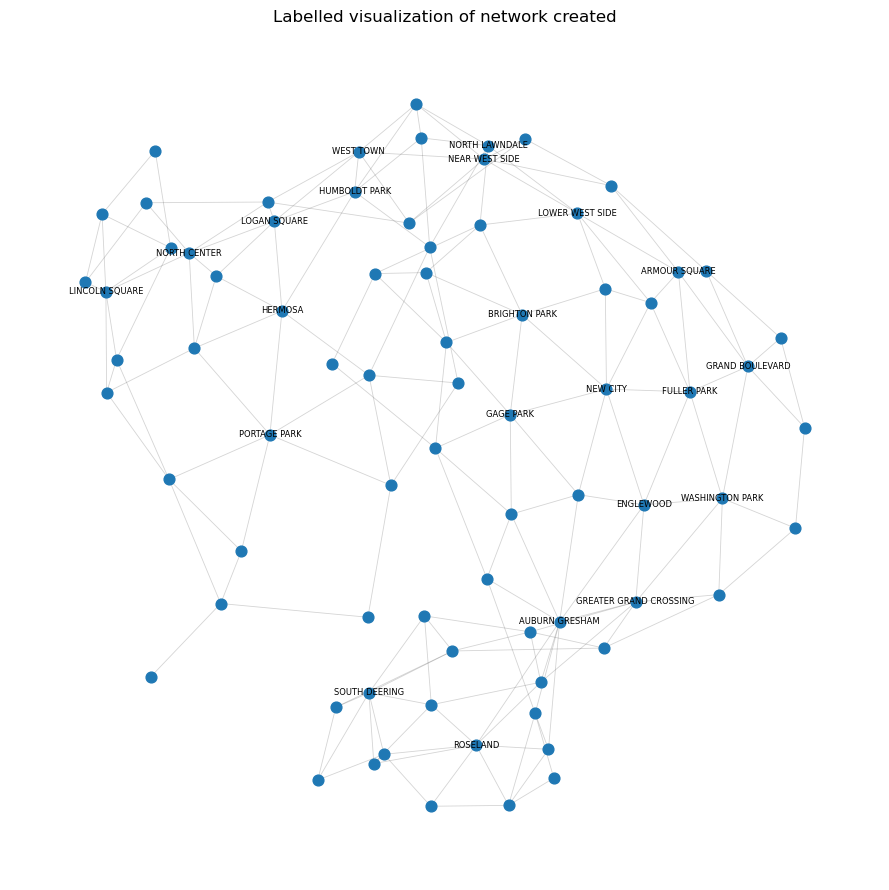

In [25]:
# --- Labelled visualization of network created 
import numpy as np
import matplotlib.pyplot as plt

# positions: force-directed (not map overlay)
pos = nx.spring_layout(G, seed=42, k=0.30)

# label only higher-degree nodes (top quartile)
deg = dict(G.degree())
cut = np.percentile(list(deg.values()), 75) if deg else 0
label_nodes = [n for n, d in deg.items() if d >= cut]
labels = {n: G.nodes[n].get("name", str(n)).upper() for n in label_nodes}

fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx_edges(G, pos, width=0.6, alpha=0.25, edge_color="#555", ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=60, ax=ax)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=6, ax=ax)

# assignment-required title:
ax.set_title("Labelled visualization of network created")

ax.axis("off")
fig.tight_layout()
plt.show()


# (1c) Plot of degree distribution

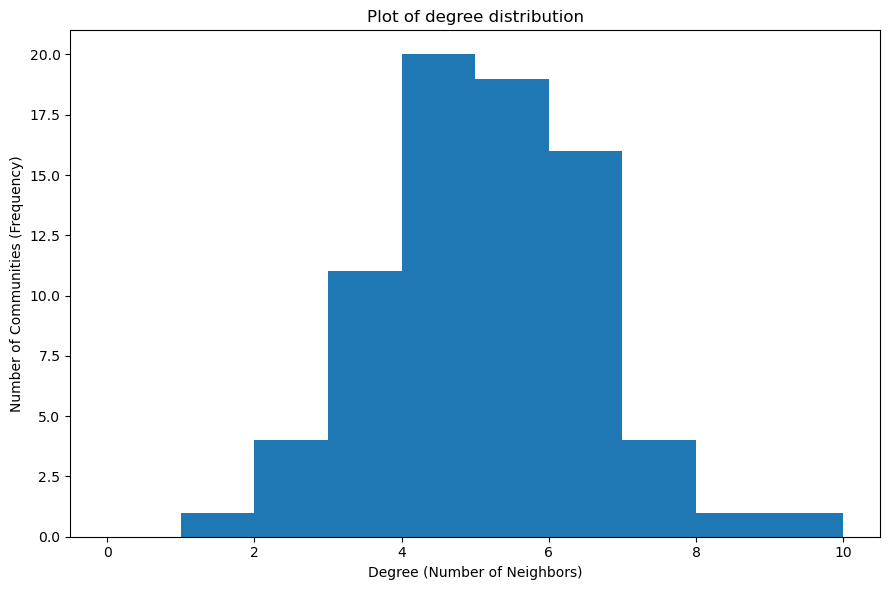

In [27]:
# --- Plot of degree distribution (histogram style) ---
vals = [d for _, d in G.degree()]
bins = range(0, (max(vals) if vals else 0) + 2)

fig, ax = plt.subplots(figsize=(9, 6))
ax.hist(vals, bins=bins)
ax.set_xlabel("Degree (Number of Neighbors)")
ax.set_ylabel("Number of Communities (Frequency)")

# assignment-required title:
ax.set_title("Plot of degree distribution")


fig.tight_layout()
plt.show()


In [12]:
print(f"Number of nodes (Community Areas): {G.number_of_nodes()}")
print(f"Number of edges (Shared Boundaries): {G.number_of_edges()}")
max_degree_node = max(G.degree, key=lambda item: item[1])
top_i = max_degree_node[0]
top_name = G.nodes[top_i].get("name", f"Area {top_i}")
print(f"Community with the most neighbors: '{top_name}' with {max_degree_node[1]} neighbors.")


Number of nodes (Community Areas): 77
Number of edges (Shared Boundaries): 179
Community with the most neighbors: 'AUBURN GRESHAM' with 9 neighbors.
